In [132]:
from jax import numpy as jnp
from matplotlib import pyplot as plt
import numpy as np

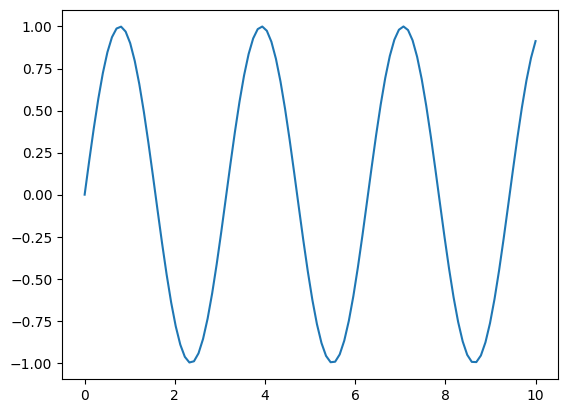

In [133]:
x = jnp.linspace(0, 10, 100)
y = 2 * jnp.sin(x) * jnp.cos(x)
plt.plot(x, y)

In [134]:
x = jnp.arange(10)
# x[4] = 10
y = x.at[4].set(10)
print(y)

[ 0  1  2  3 10  5  6  7  8  9]


In [135]:
from icecream import ic

x = jnp.arange(10).reshape(2, 5)
ic(x)

ic| x: Array([[0, 1, 2, 3, 4],
              [5, 6, 7, 8, 9]], dtype=int32)


Array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]], dtype=int32)

In [136]:
y = x.at[0, 2].set(100)
ic(y)
ic(x)

ic| y: Array([[  0,   1, 100,   3,   4],
              [  5,   6,   7,   8,   9]], dtype=int32)
ic| x: Array([[0, 1, 2, 3, 4],
              [5, 6, 7, 8, 9]], dtype=int32)


Array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]], dtype=int32)

In [137]:
from jax import random

key = random.key(0)
random.normal(key, (100, 100), dtype=jnp.float32)

Array([[ 1.3969241 ,  0.25045034, -2.1396856 , ...,  0.3145455 ,
        -1.4147886 , -0.9089208 ],
       [-0.7179685 , -0.55156016,  0.5488421 , ...,  1.0389215 ,
         0.6316356 ,  1.2083954 ],
       [ 0.1089396 ,  0.41924244,  0.61395687, ..., -0.25856677,
         2.026924  , -0.840388  ],
       ...,
       [-1.7753865 ,  0.47193787, -1.0666512 , ..., -0.05554172,
         1.7904825 , -0.38509572],
       [ 1.1479    , -0.8108315 , -0.14811768, ...,  0.29534367,
         0.20607775, -0.40122998],
       [-0.8252757 ,  0.60466516,  2.5560381 , ...,  0.07566901,
         1.3775586 ,  0.7038264 ]], dtype=float32)

In [138]:
from jax import device_put

size = 3000

# Data is automatically pushed to the AI accelerator! (DeviceArray structure)
# No more need for ".to(device)" (PyTorch syntax)
x_jnp = random.normal(key, (size, size), dtype=jnp.float32)
x_np = np.random.normal(size=(size, size)).astype(np.float32)  # some diff in API exists!

%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()  # 1) on GPU - fast
%timeit np.dot(x_np, x_np.T)  # 2) on CPU - slow (NumPy only works with CPUs)
%timeit jnp.dot(x_np, x_np.T).block_until_ready()  # 3) on GPU with transfer overhead

x_np_device = device_put(x_np)  # push NumPy explicitly to GPU
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()  # same as 1)

# Note1: I'm using GPU as a synonym for AI accelerator. 
# In reality, especially in Colab, this can also be a TPU, etc.

# Note2: block_until_ready() -> asynchronous dispatch

5.1 ms ± 147 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
102 ms ± 3.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22 ms ± 131 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.11 ms ± 167 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [139]:
# Simple helper visualization function
def visualize_fn(fn, l=-10, r=10, n=500):
    x = jnp.linspace(l, r, num=n)
    y = fn(x).block_until_ready()
    plt.plot(x, y)
    plt.show()

# JAX Transformers

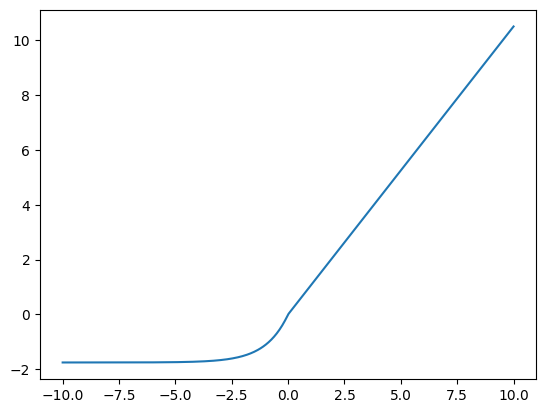

In [140]:
from jax import jit


def selu(x, alpha=1.67, lamb=1.05):
    return lamb * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)


selu_jit = jit(selu)
visualize_fn(selu_jit)

In [141]:
data = random.normal(key, (1_000_000,))
data.min(), data.max()

(Array(-4.75679, dtype=float32), Array(4.7694006, dtype=float32))

In [142]:
print('Non-jit version:')
%timeit selu(data).block_until_ready()
print('Jit version:')
%timeit selu_jit(data).block_until_ready()

Non-jit version:


462 μs ± 12.5 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Jit version:
82.8 μs ± 11.8 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# `grad()` 101 Lecture
Differentiable Programming with JAX

In [143]:
from jax import grad


def sum_logistic(x):
    return jnp.sum(1.0 / (1.0 + jnp.exp(-x)))


x = jnp.arange(3.0)
ic(x)

loss = sum_logistic
grad_loss = grad(loss)
ic(grad_loss(x))

ic| x: Array([0., 1., 2.], dtype=float32)
ic| grad_loss(x): Array([0.25      , 0.19661194, 0.10499357], dtype=float32)


Array([0.25      , 0.19661194, 0.10499357], dtype=float32)

In [144]:
# Numeric diff (to double check that autodiff works correctly)
def finite_differences(f, x):
    eps = 1e-3
    # f(0+e, 1, 2) - f(0-e, 1, 2) / 2e
    return jnp.array(
        [
            (f(x + eps * v) - f(x - eps * v)) / (2 * eps)  # derivative definition
            for v in jnp.eye(len(x))
        ]
    )


ic(finite_differences(loss, x))

ic| finite_differences(loss, x): Array([0.24998187, 0.1965761 , 0.10502338], dtype=float32)


Array([0.24998187, 0.1965761 , 0.10502338], dtype=float32)

In [145]:
x = 1.0
y = 1.0

f = lambda x, y: x**2 + x + 4 + y**2  # simple 2nd order polynomial fn
# visualize_fn(f, l=-1, r=2, n=100)

dfdx = grad(f)  # 2*x + 1
d2fdx = grad(dfdx)  # 2
d3fdx = grad(d2fdx)  # 0

# x = jnp.array(1.0)

ic(f(x, y))
ic(dfdx(x, y))
ic(d2fdx(x, y))
ic(d3fdx(x, y))

ic| f(x, y): 7.0
ic| dfdx(x, y): Array(3., dtype=float32, weak_type=True)
ic| d2fdx(x, y): Array(2., dtype=float32, weak_type=True)
ic| d3fdx(x, y): Array(0., dtype=float32, weak_type=True)


Array(0., dtype=float32, weak_type=True)

# vmap() 101

In [146]:
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))  # simulated batch


def apply_matrix(x):
    return jnp.dot(W, x)

In [147]:
def naively_batched_apply_matrix(x):
    return jnp.stack([apply_matrix(xi) for xi in x])


print('Naively batched')
%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

Naively batched


1.99 ms ± 30.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [148]:
@jit
def batched_apply_matrix(batched_x):
    return jnp.dot(batched_x, W.T)  # (10, 100) * (100, 150) -> (10, 150)

print('Manually batched')
%timeit batched_apply_matrix(batched_x).block_until_ready()

Manually batched
80.8 μs ± 1.38 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [149]:
from jax import vmap

@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(batched_x):
    return vmap(apply_matrix)(batched_x)

# Task: modify apply_matrix to have 2 inputs and use in_axes arg

print('Auto-vectorized with vmap')
%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

Auto-vectorized with vmap
84.7 μs ± 3.12 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [150]:
from jax import lax, vmap

# Example 1: lax is stricter
print(jnp.add(1, 1.0))  # jax.numpy API implicitly promotes mixed types
# print(lax.add(1, 1.0))  # jax.lax API requires explicit type promotion
print(lax.add(1, 1))

2.0
2


In [151]:
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))  # simulated batch


def apply_matrix(W, x):
    return jnp.dot(W, x)


@jit  # Note: we can arbitrarily compose JAX transforms! Here jit + vmap.
def vmap_batched_apply_matrix(W, batched_x):
    return vmap(apply_matrix, in_axes=(None, 0))(W, batched_x)


%timeit vmap_batched_apply_matrix(W, batched_x).block_until_ready()

82.6 μs ± 2.79 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [152]:
def get_negatives(x):
    return x[x < 0]


x = random.normal(key, (10,), dtype=jnp.float32)
r = get_negatives(x)
# r = jit(get_negatives)(x) # not supported
ic(r)
ic(r.shape)

ic| r: Array([-0.3721109 , -0.18252768, -0.7368197 , -0.44030377, -0.1521442 ,
              -0.67135346, -0.5908641 ], dtype=float32)
ic| r.shape: (7,)


(7,)

In [153]:
# So how does it work in the background?
#   -> tracing on different levels of abstraction
@jit
def f(x, y):
    print("Running f():")
    print(f"  x = {x}")
    print(f"  y = {y}")
    result = jnp.dot(x + 1, y + 1)
    print(f"  result = {result}")
    return result


x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x2 = np.random.randn(3, 4)
y2 = np.random.randn(4)
print("Second call:")
print(f(x2, y2))  # Oops! Side effects (like print) are not compiled...

# Note: any time we get the same shapes and types we just call the compiled fn!

x3 = np.random.randn(3, 5)
y3 = np.random.randn(5)
print("Third call:")
print(f(x3, y3))

Running f():
  x = Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[3.5260892 0.7663715 2.053677 ]
Second call:
[3.188664  2.2065854 1.4800255]
Third call:
Running f():
  x = Traced<ShapedArray(float32[3,5])>with<DynamicJaxprTrace(level=1/0)>
  y = Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=1/0)>
  result = Traced<ShapedArray(float32[3])>with<DynamicJaxprTrace(level=1/0)>
[5.1712303 2.101714  3.9290457]


In [154]:
from jax import make_jaxpr


def f(x, y):
    return jnp.dot(x + 1, y + 1)


print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,4] b:f32[4]. let
    c:f32[3,4] = add a 1.0
    d:f32[4] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


In [155]:
from functools import partial


@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x


print(f(1, True))
print(f(2, True))
print(f(2, False))
print(f(23, False))

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
-1
-2
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
2
23


In [156]:
# 3rd example of a failure:
# Task: add some print statements! (<expanding mind>)
@jit
def f(x):
    return x.reshape(np.array(x.shape).prod())


x = jnp.ones((2, 3))
f(x)

Array([1., 1., 1., 1., 1., 1.], dtype=float32)

In [157]:
x.shape

(2, 3)

In [158]:
x.reshape

<bound method _reshape of Array([[1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>

# Pure Functions

In [159]:
def impure_side_effect(x):
    print("Impure side effect!")
    return x


print("First call:", jit(impure_side_effect)(1.0))
print("Second call: ", jit(impure_side_effect)(5.0))

# JAX re-runs the Python function when the type or shape of the argument changes
print("Third call, different type: ", jit(impure_side_effect)(jnp.array([5.0])))

Impure side effect!
First call: 1.0
Second call:  5.0
Impure side effect!
Third call, different type:  [5.]


### Example 3: very important! Haiku/Flax are basically built upon this idea!

In [160]:
def pure_uses_internal_state(x):
    state = dict(even=0, odd=0)
    for i in range(10):
        state["even" if i % 2 == 0 else "odd"] += x

    return state["even"] + state["odd"]


print(jit(pure_uses_internal_state)(5.0))

50.0


### Example 4: Don't use iterator in JAX!

In [161]:
# Example 4
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i, x: x + array[i], 0))

iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i, x: x + next(iterator), 0))  # result: not 45

45
0


# Gotcha #2: In-place updates

In [162]:
jnp_array = jnp.zeros((3, 3), dtype=jnp.float32)
updated_array = jnp_array.at[1, :].set(1.0)

ic(jnp_array)
ic(updated_array)

ic| jnp_array: Array([[0., 0., 0.],
                      [0., 0., 0.],
                      [0., 0., 0.]], dtype=float32)
ic| updated_array: Array([[0., 0., 0.],
                          [1., 1., 1.],
                          [0., 0., 0.]], dtype=float32)


Array([[0., 0., 0.],
       [1., 1., 1.],
       [0., 0., 0.]], dtype=float32)

In [163]:
jax_array = jnp.ones((5, 6))
new_jax_array = jax_array.at[::2, 3:].add(7.0)

ic(jax_array)
ic(new_jax_array)

ic| jax_array: Array([[1., 1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1., 1.],
                      [1., 1., 1., 1., 1., 1.]], dtype=float32)
ic| new_jax_array: Array([[1., 1., 1., 8., 8., 8.],
                          [1., 1., 1., 1., 1., 1.],
                          [1., 1., 1., 8., 8., 8.],
                          [1., 1., 1., 1., 1., 1.],
                          [1., 1., 1., 8., 8., 8.]], dtype=float32)


Array([[1., 1., 1., 8., 8., 8.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 8., 8., 8.],
       [1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 8., 8., 8.]], dtype=float32)

In [164]:
try:
    np.arange(10)[11]
except Exception as e:
    print(e)

index 11 is out of bounds for axis 0 with size 10


In [165]:
# JAX behavior
# 1) updates at out-of-bounds indices are skipped
# 2) retrievals result in index being clamped
# in general there are currently some bugs so just consider the behavior undefined!

print(jnp.arange(12).at[11].add(23))  # example of 1)
print(jnp.arange(10).at[11].add(23))  # example of 1)
print(jnp.arange(10)[11])  # example of 2)

[ 0  1  2  3  4  5  6  7  8  9 10 34]
[0 1 2 3 4 5 6 7 8 9]
9


# Gotcha #4: Non-Array Inputs

In [166]:
try:
    ic(jnp.sum([1, 2, 3]))
except Exception as e:
    print(type(e))
    print(e)


try:
    ic()
    ic(jnp.sum(jnp.array([1, 2, 3])))
except Exception as e:
    print(type(e))
    print(e)

ic| 543358042.py:9 in <module> at 13:37:41.533
ic| jnp.sum(jnp.array([1, 2, 3])): Array(6, dtype=int32)


<class 'TypeError'>
sum requires ndarray or scalar arguments, got <class 'list'> at position 0.


In [167]:
# Why? jaxpr to the rescue!


def permissive_sum(x):
    return jnp.sum(jnp.array(x))


x = list(range(10))
ic(permissive_sum(x))

print(make_jaxpr(permissive_sum)(x))

ic| permissive_sum(x): Array(45, dtype=int32)


{ lambda ; a:i32[] b:i32[] c:i32[] d:i32[] e:i32[] f:i32[] g:i32[] h:i32[] i:i32[]
    j:i32[]. let
    k:i32[] = convert_element_type[new_dtype=int32 weak_type=False] a
    l:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] c
    n:i32[] = convert_element_type[new_dtype=int32 weak_type=False] d
    o:i32[] = convert_element_type[new_dtype=int32 weak_type=False] e
    p:i32[] = convert_element_type[new_dtype=int32 weak_type=False] f
    q:i32[] = convert_element_type[new_dtype=int32 weak_type=False] g
    r:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
    s:i32[] = convert_element_type[new_dtype=int32 weak_type=False] i
    t:i32[] = convert_element_type[new_dtype=int32 weak_type=False] j
    u:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] k
    v:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] l
    w:i32[1] = broadcast_in_dim[broadcast_dimensions=() shap

# Gotcha #5: Random Numbers

In [168]:
# NumPy - PRNG is stateful!
seed = 123

# Let's sample calling the same function twice
ic(np.random.random())
ic(np.random.random())

np.random.seed(seed)

rng_state = np.random.get_state()
ic(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
ic(rng_state[2:])

_ = np.random.uniform()
rng_state = np.random.get_state()
ic(rng_state[2:])

# Mersenne Twister PRNG is known to have a number of problems (NumPy's imp of PRNG)

ic| np.random.random(): 0.8053733773370335
ic| np.random.random(): 0.37761216615651516
ic| rng_state[2:]: (624, 0, 0.0)
ic| rng_state[2:]: (2, 0, 0.0)
ic| rng_state[2:]: (4, 0, 0.0)


(4, 0, 0.0)

In [169]:
# JAX's random functions can't modify PRNG's state!

key = random.PRNGKey(seed)
# key = random.key(seed)
print(key)  # key defines the state (2 unsigned int32s)

# Let's again sample calling the same function twice
print(random.normal(key, shape=(1,)))
print(key)  # verify that the state hasn't changed

print(random.normal(key, shape=(1,)))  # oops - same results?
print(key)

[  0 123]
[-0.75307846]
[  0 123]
[-0.75307846]
[  0 123]


In [170]:
# Solution? -> Split every time you need a pseudorandom number.

print("old key", key)
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
print("    \---SPLIT --> new key   ", key)
print("             \--> new subkey", subkey, "--> normal", normal_pseudorandom)

# Note1: you can also split into more subkeys and not just 1
# Note2: key, subkey no difference it's only a convention

old key [  0 123]
    \---SPLIT --> new key    [1896456402   17229315]
             \--> new subkey [4081828428 1707601653] --> normal [-1.7093881]


In [171]:
# Why this design?
# Well...think...with current design can the code be:

# 1) reproducible?
# 2) parallelizable?
# 3) vectorizable?

np.random.seed(seed)


def bar():
    return np.random.uniform()


def baz():
    return np.random.uniform()


# e.g. bar=0.3 baz=0.4 [0.3 + 2*0.4] [0.4 + 2*0.3] -> not reproducible in parallel envs!
def foo():
    return bar() + 2 * baz()


print(foo())

# What if we want to parallelize this code? NumPy assumes too much. 2) is violated.

1.2687478554986207


In [172]:
# NumPy
np.random.seed(seed)
print("individually:", np.stack([np.random.uniform() for _ in range(3)]))

np.random.seed(seed)
print("all at once: ", np.random.uniform(size=3))

# JAX
key = random.PRNGKey(seed)
subkeys = random.split(key, 3)

ic(key)
ic(subkeys)

ic| key: Array([  0, 123], dtype=uint32)
ic| subkeys: Array([[1653257682, 1672999557],
                    [ 925083257,  785867247],
                    [3496285182, 3330727308]], dtype=uint32

individually: [0.69646919 0.28613933 0.22685145]
all at once:  [0.69646919 0.28613933 0.22685145]


)


Array([[1653257682, 1672999557],
       [ 925083257,  785867247],
       [3496285182, 3330727308]], dtype=uint32)

In [173]:
sequence = np.stack([random.normal(subkey) for subkey in subkeys])
print("individually:", sequence)

key = random.PRNGKey(seed)
print("all at once: ", random.normal(key, shape=(3,)))

# NumPy violates 3)

individually: [0.5295926 0.9010755 2.569989 ]
all at once:  [-0.1470326  0.5524756  1.648498 ]


# Gotcha #6: Control Flow Primitives

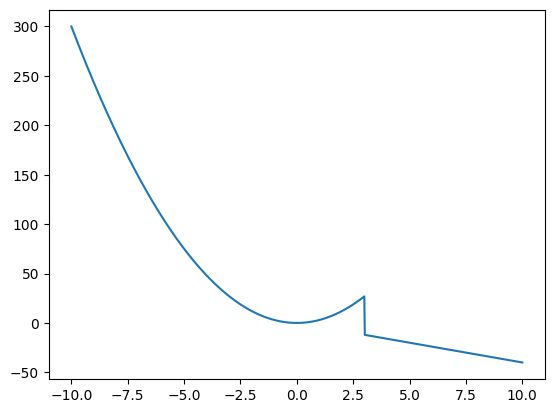

12.0
-4.0


In [174]:
# Python control flow + grad() -> everything is ok
def f(x):
    if x < 3:
        return 3.0 * x**2
    else:
        return -4 * x


x = np.linspace(-10, 10, 1000)
y = [f(el) for el in x]
plt.plot(x, y)
plt.show()

print(grad(f)(2.0))  # ok!
print(grad(f)(4.0))  # ok

In [175]:
# Python control flow + jit() -> problems in paradise.

# "The tradeoff is that with higher levels of abstraction we gain a more general view
# of the Python code (and thus save on re-compilations),
# but we require more constraints on the Python code to complete the trace."

# Example 1: conditioning on value (same function as in the above cell)
# Solution (recall: we already have seen this)
f_jit = jit(f, static_argnums=(0,))
x = 2.0

print(make_jaxpr(f_jit, static_argnums=(0,))(x))
print(f_jit(x))

ic(f(2))

ic| f(2): 12.0


{ lambda ; . let
    a:f32[] = pjit[name=f jaxpr={ lambda ; . let  in (12.0,) }] 
  in (a,) }
12.0


12.0

In [176]:
# Example 2: range depends on value again


def f(x, n):
    y = 0.0
    for i in range(n):
        y = y + x[i]
    return y


f_jit = jit(f, static_argnums=(1,))
x = (jnp.array([2.0, 3.0, 4.0]), 15)

print(make_jaxpr(f_jit, static_argnums=(1,))(*x))  # notice how for loop gets unrolled
print(f_jit(*x))

# Note: there is a catch - static args should not change a lot!

# f([2, 3, 4], 15)

{ lambda ; a:f32[3]. let
    b:f32[] = pjit[
      name=f
      jaxpr={ lambda ; c:f32[3]. let
          d:f32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=None] c
          e:f32[] = squeeze[dimensions=(0,)] d
          f:f32[] = add 0.0 e
          g:f32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=None] c
          h:f32[] = squeeze[dimensions=(0,)] g
          i:f32[] = add f h
          j:f32[1] = slice[limit_indices=(3,) start_indices=(2,) strides=None] c
          k:f32[] = squeeze[dimensions=(0,)] j
          l:f32[] = add i k
          m:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 3
          n:f32[] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), start_index_map=(0,))
            fill_value=None
            indices_are_sorted=True
            mode=GatherScatterMode.PROMISE_IN_BOUNDS
            slice_sizes=(1,)
            unique_indices=True
          ] c m
          o:f32[] =

In [177]:
# Even "better" (it's less readable) solution is to use low level API
def f_fori(x, n):
    body_fun = lambda i, val: val + x[i]
    return lax.fori_loop(0, n, body_fun, 0.0)


f_fori_jit = jit(f_fori)

print(make_jaxpr(f_fori_jit)(*x))
print(f_fori_jit(*x))

{ lambda ; a:f32[3] b:i32[]. let
    c:f32[] = pjit[
      name=f_fori
      jaxpr={ lambda ; d:f32[3] e:i32[]. let
          _:i32[] _:i32[] f:f32[] = while[
            body_jaxpr={ lambda ; g:f32[3] h:i32[] i:i32[] j:f32[]. let
                k:i32[] = add h 1
                l:bool[] = lt h 0
                m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
                n:i32[] = add m 3
                o:i32[] = select_n l h n
                p:f32[1] = dynamic_slice[slice_sizes=(1,)] g o
                q:f32[] = squeeze[dimensions=(0,)] p
                r:f32[] = convert_element_type[
                  new_dtype=float32
                  weak_type=False
                ] j
                s:f32[] = add r q
              in (k, i, s) }
            body_nconsts=1
            cond_jaxpr={ lambda ; t:i32[] u:i32[] v:f32[]. let
                w:bool[] = lt t u
              in (w,) }
            cond_nconsts=0
          ] d 0 e 0.0
        in (f,) }
    ] a b
  

# Gotcha #7: NaNs

In [180]:
import jax

jax.config.update("jax_debug_nans", True)

AttributeError: module 'jax.config' has no attribute 'update'

In [129]:
import jax.config as config

config.update("jax_debug_nans", True)


def f(x, y):
    return x / y


jax.jit(f)(0.0, 0.0)  # ==> raises FloatingPointError exception!

AttributeError: module 'jax.config' has no attribute 'update'

In [ ]:
import jax

jnp.divide(
    0.0, 0.0
)  # the default non-error behavior will simply return a NaN (as usually)

# If you want to debug where the NaNs are coming from, there are multiple ways
# to do that, here is one:
# from jax import config
# dir(config)
jax.config.update("jax_debug_nans", True)

jnp.divide(
    0.0, 0.0
)  # the default non-error behavior will simply return a NaN (as usually)

AttributeError: module 'jax.config' has no attribute 'update'